I want to get familiar with the `brian2` neuron and neuron populations simulator; hence, this notebook.

# Part I: Neurons

## Imports and Setup

In [1]:
%matplotlib inline

from brian2 import *

`brian2` has a system for using quantities with physical dimensions. All the basic SI units can be used along with their standard prefixes, and some standard abbreviations:

In [2]:
20 * volt

20. * volt

In [3]:
1000 * amp

1. * kamp

In [4]:
100 * namp

100. * namp

In [5]:
10 * nA * 5 * Mohm

50. * mvolt

This should produce a DimensionMismatchError:

In [6]:
5 * amp + 10 * volt

DimensionMismatchError: Cannot calculate 5. A + 10. V, units do not match (units are amp and volt).

## A simple model

Let's start by defining a simple neuron model. In `brian2`, all models are defined by systems of differential equations. Here's a simple example:

In [7]:
tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau : 1
'''

Equations are given by a multi-line string with one equation per string. The equations are formatted with standard mathematical notation, but with one exception: at the end of each line, we write `: unit` where `unit` is the SI unit of the variable in the differential equation.

Let's use this definition to create a neuron:

In [8]:
G = NeuronGroup(1, eqs, method='linear')

In `brian2`, we can only create groups of neurons using the class `NeuronGroup`. The first two arguments when you create one of these objects are the number of neurons and their defining differential equations.

The command `run(100*ms)` runs the simulation for 100ms. We can see that it has worked by printing out the value of `v` before and after the simulation.

In [9]:
print('Before v = %s' % G.v[0])
run(100*ms)
print('After v = %s' % G.v[0])

Before v = 0.0
After v = 0.99995460007


By default, all variables start with value 0. Since the differential equation is `dv/dt = (1-v)/tau`, we would expect after a while that `v` would tend towards 1, which is what we've observed. Specifically, we should expect to see that `v` has the value `1-exp(-t/tau)`. Let's check this:

In [10]:
print('Expected value of v = %s' % (1 - exp(-100 * ms / tau)))

Expected value of v = 0.99995460007


The simulation gives the expected value!

Now, let's look at a plot of how the value `v` evolves over time:

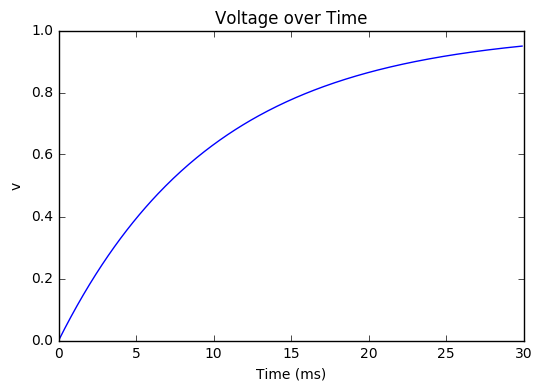

In [11]:
# so this code doesn't depend on previously defined variables
start_scope()

G = NeuronGroup(1, eqs, method='linear')
M = StateMonitor(G, 'v', record=0)

run(30*ms)

plot(M.t / ms, M.v[0])
xlabel('Time (ms)');
ylabel('v');
title('Voltage over Time');

We ran the simulation only for 30ms so we can see the behavior better. It looks like its behaving as expected, but let's check it analytically by plotting the expected behavior as well.

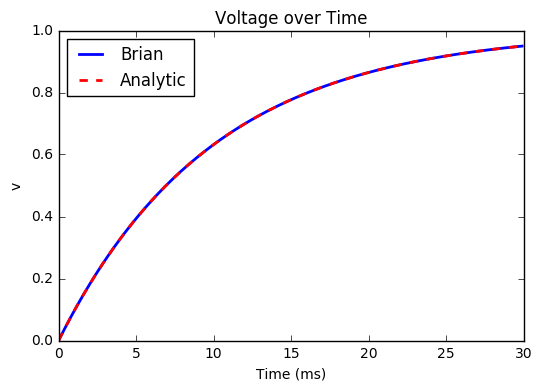

In [12]:
start_scope()

G = NeuronGroup(1, eqs, method='linear')
M = StateMonitor(G, 'v', record=0)

run(30*ms)

plot(M.t/ms, M.v[0], '-b', lw=2, label='Brian')
plot(M.t/ms, 1-exp(-M.t/tau), '--r', lw=2, label='Analytic')
xlabel('Time (ms)');
ylabel('v');
legend(loc='best');
title('Voltage over Time');

Clearly, the blue line (`brian2` simulation) and the red line (analytic solution) coincide.

Now, we modify the equations and its parameters and see what happens in the plot of the simulation:

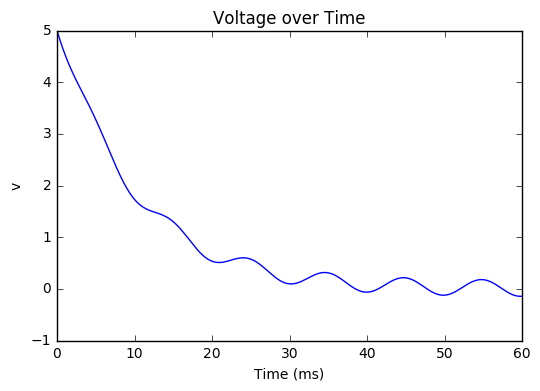

In [13]:
start_scope()

tau = 10*ms
eqs = '''
dv/dt = (sin(2*pi*100*Hz*t)-v)/tau : 1
'''

# Change to Euler's method since exact integration doesn't work for this differential equation
G = NeuronGroup(1, eqs, method='euler')
M = StateMonitor(G, 'v', record=0)

# Initial value for v
G.v = 5

run(60*ms)

plot(M.t/ms, M.v[0])
xlabel('Time (ms)');
ylabel('v');
title('Voltage over Time');

## Adding Spikes

So far we haven't done anything neuronal, just played around with differential equations. Let's start adding spiking behavior.

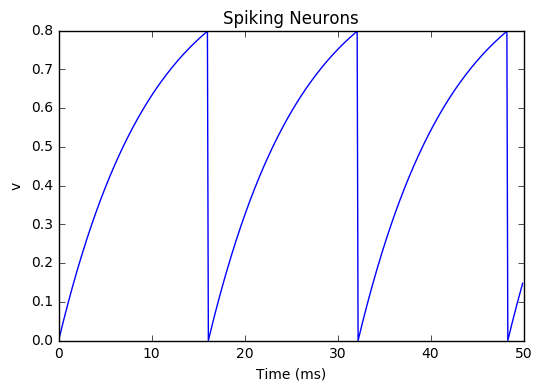

In [14]:
start_scope()

tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau : 1
'''

# creating a single neuron which "spikes" at v = 0.8 and resets to v = 0
G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v=0', method='linear')
M = StateMonitor(G, 'v', record=0)

run(50*ms)
plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v')
title('Spiking Neurons');

We've added two keywords to the `NeuronGroup` declaration: `threshold='v>0.8'` and `reset='v=0'`. This means that whenever `v>0.8` we "fire" a spike and immediately reset `v=0` afterwards. We can put any expression or series of statements as these arguments.

At the beginning of the simulation, the behavior is the same as before until `v` crosses the threshold of `v>0.8`, at which point `v` resets to `0`. You can't see this in the figure, but internally, `brian2` has registered this as a spike. Let's take a look at this.

In [15]:
start_scope()

G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v=0', method='linear')

# creating a 'SpikeMonitor' object to record spike activity
spikemon = SpikeMonitor(G)

run(50*ms)

print('Spike times: %s' % spikemon.t[:])

creating /tmp/scipy-dan-JIpGqd/python27_intermediate/compiler_dc7ecac41cfd71b2db4283a38d127b00
Spike times: [ 16.   32.1  48.2] ms


The `SpikeMonitor` object takes the group whose spikes we'd like to record as its argument, and stores the spike tiems in the variable `t`. Let's plot the spikes on top of the other figure to see that it's getting the times right.

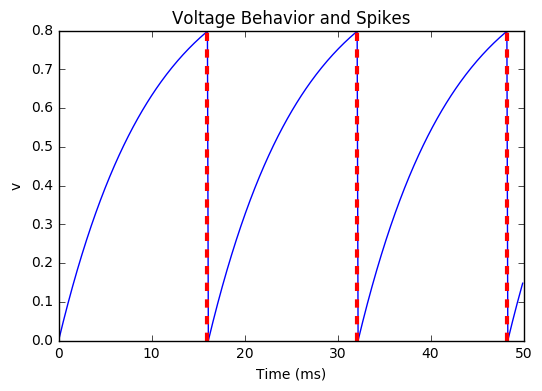

In [16]:
start_scope()

G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v=0', method='linear')

# creating both 'StateMonitor' and 'SpikeMonitor' objects
statemon = StateMonitor(G, 'v', record=0)
spikemon = SpikeMonitor(G)

run(50*ms)

plot(statemon.t/ms, statemon.v[0])
for t in spikemon.t:
    axvline(t/ms, ls='--', c='r', lw=3)
xlabel('Time (ms)')
ylabel('v')
title('Voltage Behavior and Spikes');

Let's try a few more settings for the `threshold` and `reset` arguments.

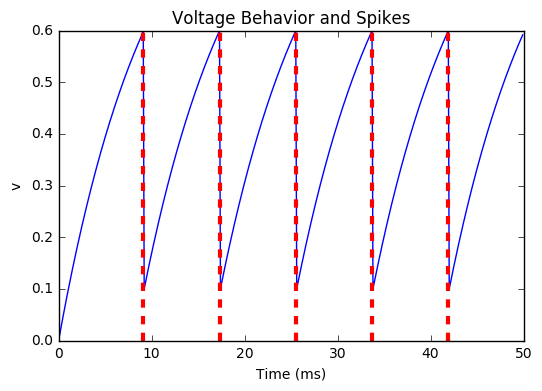

In [17]:
start_scope()

G = NeuronGroup(1, eqs, threshold='v>0.6', reset='v=0.1', method='linear')

# creating both 'StateMonitor' and 'SpikeMonitor' objects
statemon = StateMonitor(G, 'v', record=0)
spikemon = SpikeMonitor(G)

run(50*ms)

plot(statemon.t/ms, statemon.v[0])
for t in spikemon.t:
    axvline(t/ms, ls='--', c='r', lw=3)
xlabel('Time (ms)')
ylabel('v')
title('Voltage Behavior and Spikes');

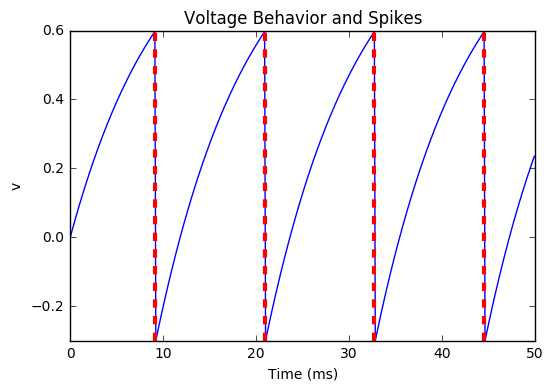

In [18]:
start_scope()

G = NeuronGroup(1, eqs, threshold='v>0.6', reset='v=-0.3', method='linear')

# creating both 'StateMonitor' and 'SpikeMonitor' objects
statemon = StateMonitor(G, 'v', record=0)
spikemon = SpikeMonitor(G)

run(50*ms)

plot(statemon.t/ms, statemon.v[0])
for t in spikemon.t:
    axvline(t/ms, ls='--', c='r', lw=3)
xlabel('Time (ms)')
ylabel('v')
title('Voltage Behavior and Spikes');

## Refractoriness

A common feature of neuron models is refractoriness; i.e., after a neuron fires, it become refractory, or inactive, for a certain duration and cannot fire another spike until this period is over. Here's how we do that in `brian2`:

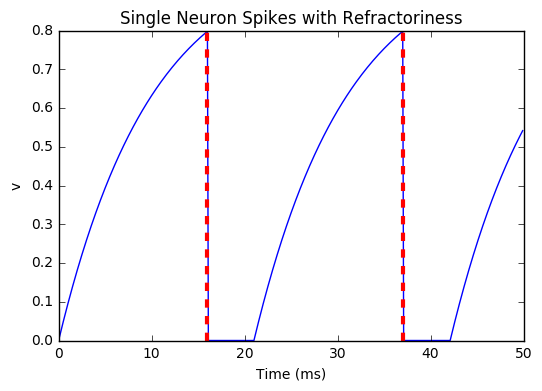

In [19]:
start_scope()

# setting up equations and time scale
tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau : 1 (unless refractory)
'''

# simulating one neuron with the same 'threshold' and 'reset' args, but with a 5ms refractory period
G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v=0', refractory=5*ms, method='linear')

# creating state and spike monitor objects
statemon = StateMonitor(G, 'v', record=0)
spikemon = SpikeMonitor(G)

run(50*ms)

plot(statemon.t/ms, statemon.v[0])
for t in spikemon.t:
    axvline(t/ms, ls='--', c='r', lw=3)
xlabel('Time (ms)')
ylabel('v')
title('Single Neuron Spikes with Refractoriness');

From this figure, after the first spike, we see that `v` stays at 0 for around 5ms before it resumes its normal behavior. To do this, we've done two things: added the keyword `refractory=5*ms` to the `NeuronGroup` declaration, and added the `(unless refractory)` to the end of the definition of `v` in the differential equations. The first means only that `v` cannot spike in the refractory period, and the second switches off the evolution of the differential equation when the neuron is refractory.

Here's what would happen if we didn't include the `(unless refractory)`. Note that we've also decreased the value of `tau` and increased the length of the refractory period to make the behavior clear.

Spike times: [  8.   23.1  38.2] ms


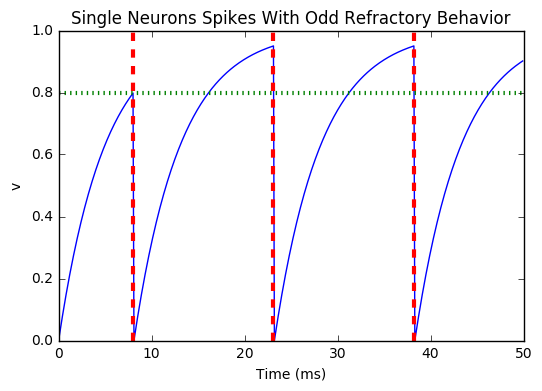

In [20]:
start_scope()

# setting up time scale and differential equations
tau = 5*ms
eqs = '''
dv/dt = (1-v)/tau : 1
'''

# creating a single neuron with same 'threshold' and 'reset' args, and 15ms refractory period
G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v=0', refractory=15*ms, method='linear')

# setting up state and spike monitor objects
statemon = StateMonitor(G, 'v', record=0)
spikemon = SpikeMonitor(G)

run(50*ms)

plot(statemon.t/ms, statemon.v[0])
for t in spikemon.t:
    axvline(t/ms, ls='--', c='r', lw=3)
axhline(0.8, ls=':', c='g', lw=3)
xlabel('Time (ms)')
ylabel('v')
title('Single Neurons Spikes With Odd Refractory Behavior');
print("Spike times: %s" % spikemon.t[:])

What's going on here? The behavior for the first spike is the same: `v` rises to 0.8 and then fires a spike at time 8ms before immediately resetting back to 0. Since the refractory period is no 15ms, this means the neuron won't be able to spike again until time 8ms + 15ms = 23ms. Immediately after the spike, the value of `v` again begins to rise since we didn't specify `(unless refractory)` in the definition of `dv/dt`. Once it reaches the threshold value of 0.8, however, it does not fire a spike even though it exceeds the `v>0.8` threshold. This is because the neuron is still refractory until time 23ms, at which point it fires a spike.

See the full `brian2` documentation for more options and use cases with spikes.

## Multiple Neurons

So far we've only being working with a single neuron. Let's do something interesting with multiple neurons!

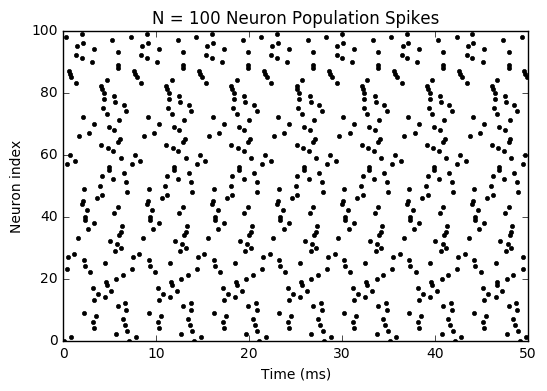

In [21]:
start_scope()

# using 100 neurons, 10ms time scale, and slightly different 
# differential equation for simulation
N = 100
tau = 10*ms
eqs = '''
dv/dt = (2-v)/tau : 1
'''

# creating the neuron group w/ voltage threshold at 1 and resetting to 0
G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', method='linear')

# instantiate each neuron with a random voltage
G.v = 'rand()'

# create spike monitor object
spikemon = SpikeMonitor(G)

run(50*ms)

plot(spikemon.t/ms, spikemon.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')
title('N = 100 Neuron Population Spikes');

We have a new variable `N` which determines the number of neurons, we've added the statement `G.v = rand()` before the run (which inititializes each neurons with a random value uniformly in $\[0, 1\]$, so each neuron does something a bit different), and we've plotted the spikes of each neuron by index over time.

As well as the variable `SpikeMonitor.t` (which gives the times of all the spikes), we've also used the variable `SpikeMonitor.i`, which gives the corresponding neuron index for each spike. We plotted a single black dot with time on the x-axis and neuron index on the y-axis. This is the standard "raster plot" used in neuroscience.

## Parameters

To make these multiple neurons do something more interesting, let's introduce per-neuron parameters that don't have a differential equation attached to them.

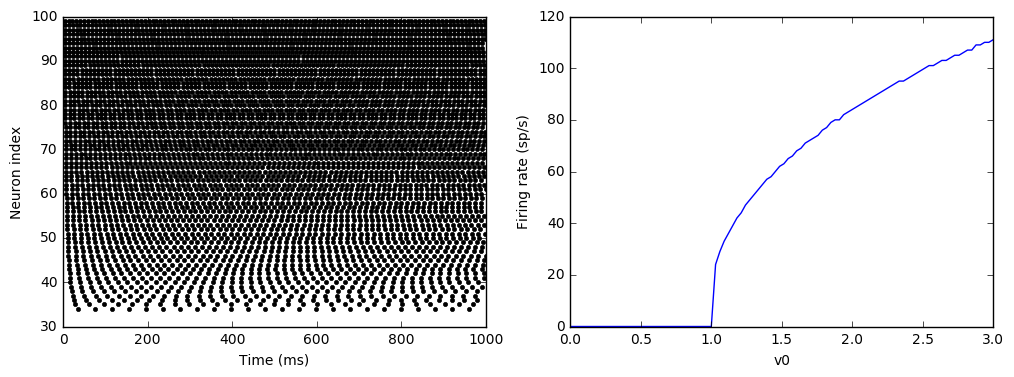

In [22]:
start_scope()

# number of neurons, time scale, initial voltage maximum, and duration of simulation
N = 100
tau = 10*ms
v0_max = 3.
duration = 1000*ms

# differential equations for neurons
eqs = '''
dv/dt = (v0-v)/tau : 1 (unless refractory)
v0 : 1
'''

# creating neuron group of size N with corresponding equations,
# threshold and reset at 1, 0, and 5ms refractory
G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', refractory=5*ms, method='linear')
M = SpikeMonitor(G)

# initial voltage based on neuron index
G.v0 = 'i*v0_max/(N-1)'

run(duration)

figure(figsize=(12,4))
subplot(121)
plot(M.t/ms, M.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')
subplot(122)
plot(G.v0, M.count/duration)
xlabel('v0')
ylabel('Firing rate (sp/s)');

The line `v0 : 1` declares a new per-neuron parameter `v0` with units `1` (dimensionless). The line `G.v0 = 'i*v0_max/(N-1)'` initializes the value of `v0` for each neuron, varying from 0 up to `v0_max`. The symbol `i`, when it appears in equations like this, refers to the index of a neuron.

In this example, we're driving the neuron towards the value `v0` exponentially quickly, but we fire spikes when `v` crosses `v>1` and resets to 0. The effect is that the rate at which each neuron fires spikes will be related to the value of `v0`. For `v0<1` it will never fire a spike, and as `v0` gets larger it will fire spikes at a higher rate. The right hand plot show the firing rate as a function of the value of `v0`. This is called the "I-f curve" of this neuron model.

Note that in the plot we've used the `count` variable of the `SpikeMonitor`. This is an array of the number of spikes each neuron in the group fired. Dividing this by the duration of the run gives the firing rate.

## Stochastic Neurons

Often when making models of neurons, we include a random element to model the effect of various forms of neural noise. In `brian2`, we can do this by using the symbol `xi` in differential equations. Strictly speaking, this symbol is a __stochastic differential__, but you can think of it as a Gaussian random variable with mean 0 and standard deviation 1. We do have to take into account the way stochastic differentials scale with time, which is why we multiply it by `tau ** -0.5` in the equations below.

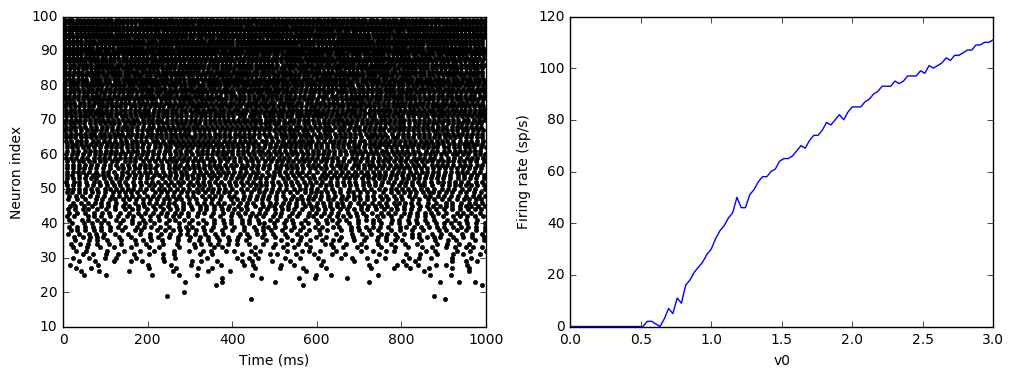

In [23]:
start_scope()

# number of neurons, time scale, max starting voltage, duration of simulation, and 'sigma' (?)
N = 100
tau = 10*ms
v0_max = 3.
duration = 1000*ms
sigma = 0.2

# differential equations (now with stochastic differential (SD) for modeling neural noise)
eqs = '''
dv/dt = (v0-v)/tau+sigma*xi*tau**-0.5 : 1 (unless refractory)
v0 : 1
'''

# creating group of neurons to simulate (solving with Euler's method (possible due to SD))
G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', refractory=5*ms, method='euler')
# creating spike monitor object on G
M = SpikeMonitor(G)

# specifying firing rate for each neuron i in [1, ..., N]
G.v0 = 'i*v0_max/(N-1)'

run(duration)

figure(figsize=(12,4))
subplot(121)
plot(M.t/ms, M.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')
subplot(122)
plot(G.v0, M.count/duration)
xlabel('v0')
ylabel('Firing rate (sp/s)');

This simulation ends up given the same figure as in the last simulation, but with some noise added. Note how the firing rate vs `v0` curve has changed shape: instead of a sharp jump from firing at rate 0 to firing at a positive rate, it now increases in a sigmoidal (S-shaped) fashion. This is because no matter how small the driving force, the randomness may cause a neuron to fire a spike.

## End of Part I

This is the end of the "Neurons" part of the tutorial. The cell below has an additional example, which we inspect in order to find out what it accomplishes and why.

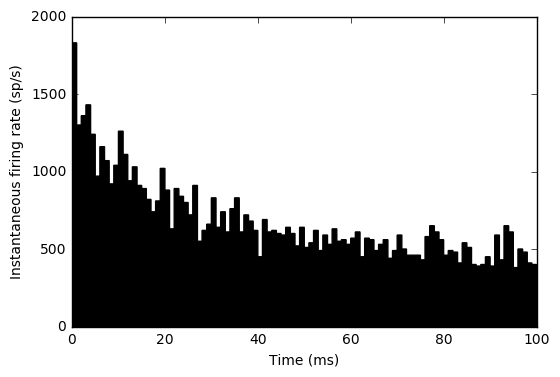

In [24]:
start_scope()

# number of neurons, time scale, 'vr' (?), 'vt0' (?), 'delta_vt0' (?), 'tau_t' (?),
# 'sigma' (?), 'v_drive' (?), duration of simulation
N = 1000
tau = 10*ms
vr = -70*mV
vt0 = -50*mV
delta_vt0 = 5*mV
tau_t = 100*ms
sigma = 0.5*(vt0-vr)
v_drive = 2*(vt0-vr)
duration = 100*ms

# differential equations (dv/dt and dvt/dt (?))
eqs = '''
dv/dt = (v_drive+vr-v)/tau + sigma*xi*tau**-0.5 : volt
dvt/dt = (vt0-vt)/tau_t : volt
'''

# reset equations
reset = '''
v = vr
vt += delta_vt0
'''

# creating group of 1000 neurons and spike monitor object
G = NeuronGroup(N, eqs, threshold='v>vt', reset=reset, refractory=5*ms, method='euler')
spikemon = SpikeMonitor(G)

# setting initial variable states
G.v = 'rand()*(vt0-vr)+vr'
G.vt = vt0

run(duration)

_ = hist(spikemon.t/ms, 100, histtype='stepfilled', facecolor='k', weights=ones(len(spikemon))/(N*defaultclock.dt))
xlabel('Time (ms)')
ylabel('Instantaneous firing rate (sp/s)');

# Part II: Synapses

## The Simplest Synapse

Once we have the neurons, the next step is to connect them up with synapses. We'll start by using the simplest possible type of synapse, which causes an instantaneous change in the postsynaptic neuron membrane potential after the spike.

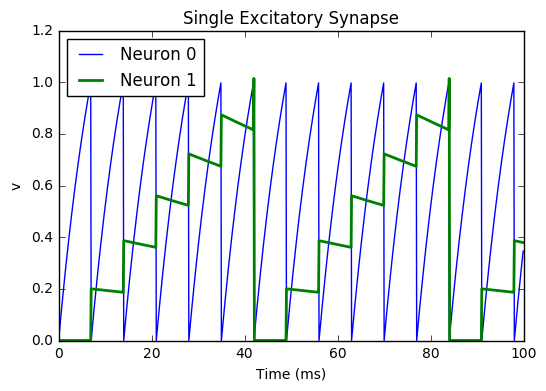

In [29]:
start_scope()

# differential equations
eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''

# setting up neuron group, current, and time scales
G = NeuronGroup(2, eqs, threshold='v>1', reset='v=0', method='linear')
G.I = [2, 0]
G.tau = [10, 100] * ms

# set up and connect a single synapse from first to second neuron
S = Synapses(G, G, on_pre='v_post += 0.2')
S.connect(i=0, j=1)

# set up state monitor object
M = StateMonitor(G, 'v', record=True)

run(100*ms)

# plotting results of simulation
plot(M.t/ms, M.v[0], '-b', label='Neuron 0')
plot(M.t/ms, M.v[1], '-g', lw=2, label='Neuron 1')
xlabel('Time (ms)')
ylabel('v')
legend(loc='best')
title('Single Excitatory Synapse');

There are a few things going on here. Let's recap what's going on with the NeuronGroup first. We've created two neurons, each of which has the same differential equation but different values for parameters `I` and `tau`. Neuron 0 has `I = 2` and `tau = 10 * ms`, which means that it's driven to repeatedly spike at a fairly high rate. Neuron 1 has `I = 0` and `tau = 100 * ms`, which means that on its own (without the synapse) it won't spike at all (the driving current `I` is 0). We can see this by commenting out the lines that define the synapse.

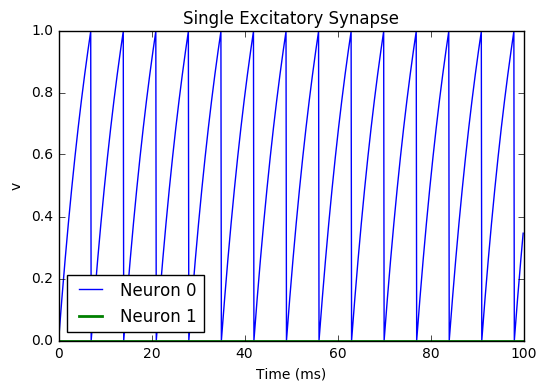

In [30]:
start_scope()

# differential equations
eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''

# setting up neuron group, current, and time scales
G = NeuronGroup(2, eqs, threshold='v>1', reset='v=0', method='linear')
G.I = [2, 0]
G.tau = [10, 100] * ms

# set up and connect a single synapse from first to second neuron
# S = Synapses(G, G, on_pre='v_post += 0.2')
# S.connect(i=0, j=1)

# set up state monitor object
M = StateMonitor(G, 'v', record=True)

run(100*ms)

# plotting results of simulation
plot(M.t/ms, M.v[0], '-b', label='Neuron 0')
plot(M.t/ms, M.v[1], '-g', lw=2, label='Neuron 1')
xlabel('Time (ms)')
ylabel('v')
legend(loc='best')
title('Single Excitatory Synapse');

Next, we define the synapses: `Synapses(source, targets, ...)` means that we are defining a synaptic model that goes from source to target. In this case, the source and target are both the same, the group `G`. The syntax `on_pre='v_post += 0.2'` means that when a spike occurs in the presynaptic neuron (hence `on_pre`), it causes an instantaneous change to happen `v_post += 0.2`. The `_post` means that the value of `v` referred to is the post-synaptic value, and it is to be increased by 0.2. In short, this model says that whenever two neurons in `G` are connected by a synapse, when the source neuron fires a spike, the target neuron will have its value of `v` increased by 0.2.

At this point we have only defined the synapse model, but we haven't actually created any synapses. The next line (`S.connect(i=0, j=1)`) creates a synapse from neuron 0 to neuron 1.

## Adding a Weight

In the previous section, we hardcoded the weight of the synapse to be the value 0.2, but we often want this to be different for different synapses. We do this by introducing synapse equations.

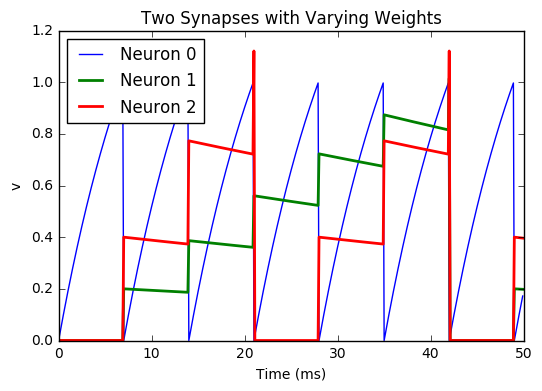

In [47]:
start_scope()

# define differential equations
eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''

# defining neuron group, currents, and time scales
G = NeuronGroup(3, eqs, threshold='v>1', reset='v=0', method='linear')
G.I = [2, 0, 0]
G.tau = [10, 100, 100] * ms

# defining synapses and their connections and weights
S = Synapses(G, G, 'w : 1', on_pre='v_post += w')
S.connect(i=0, j=[1, 2])
S.w = 'j * 0.2'

# state monitor object
M = StateMonitor(G, 'v', record=True)

run(50*ms)

plot(M.t/ms, M.v[0], '-b', label='Neuron 0')
plot(M.t/ms, M.v[1], '-g', lw=2, label='Neuron 1')
plot(M.t/ms, M.v[2], '-r', lw=2, label='Neuron 2')
xlabel('Time (ms)')
ylabel('v')
legend(loc='best')
title('Two Synapses with Varying Weights');

This example behaves similarly to the previous example, but now there's a synaptic weight variable `w`. The string `w : 1` is an equation string, exactly the same as for neurons, which defines a single dimensionless parameter `w`. We changed the behavior on a spike to `on_pre='v_post += w'` so that each synapse can behave differently depending on the value of `w`. To see this, we've made a third neuron which behaves the same as the second neuron, and connected neuron 0 to both neurons 1 and 2. We've set the weights via `S.w = 'j * 0.2'`. When `i` and `j` occur in the context of synapses, `i` refers to the presynaptic (source) neuron index, and `j` to the postsynaptic (target) neuron index. So, this will give a synaptic connection from 0 to 1 with weight `0.2 = 0.2 * 1`, and from 0 to 2 with weight `0.4 = 0.2 * 2`.

## Introducing a Delay

So far the synapses have transmitted action potentials instantaneously, but we can also make them act with a certain delay.

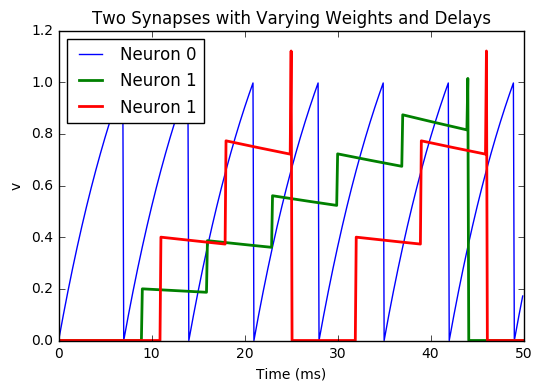

In [49]:
start_scope()

# setting up differential equations
eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''

# setting up neuron group, driving currents, and time scales
G = NeuronGroup(3, eqs, threshold='v>1', reset='v=0', method='linear')
G.I = [2, 0, 0]
G.tau = [10, 100, 100] * ms

# setting up synapses, connections, weights, and delay
S = Synapses(G, G, 'w : 1', on_pre='v_post += w')
S.connect(i=0, j=[1, 2])
S.w = 'j * 0.2'
S.delay = 'j * 2 * ms'

# state monitor object
M = StateMonitor(G, 'v', record=True)

run(50*ms)

plot(M.t/ms, M.v[0], '-b', label='Neuron 0')
plot(M.t/ms, M.v[1], '-g', lw=2, label='Neuron 1')
plot(M.t/ms, M.v[2], '-r', lw=2, label='Neuron 1')
xlabel('Time (ms)')
ylabel('v')
legend(loc='best')
title('Two Synapses with Varying Weights and Delays');

Adding delays is as simple as adding the line `S.delay = 'j * 2 * ms'`, which causes the synapse from 0 to 1 to have a propagating delay of 1 * 2ms = 2ms, and the synapse from 0 to 2 to have a propagating delay of 2 * 2ms = 4ms.

## More Complex Connectivity

So far, we've specified the connectivity explicitly, but for larger networks this isn't usually possible. For that, we shall want to specify some condition on the connectivity.

In [50]:
start_scope()

N = 10 # number of neurons
G = NeuronGroup(N, 'v : 1') # neuron group object
S = Synapses(G, G) # synapses from G to G
S.connect(condition='i != j', p=0.2) # connectivity pattern -> all to all others each with probability 0.2

We've created a dummy neuron group of `N` neurons and a dummy synapses model which doesn't actually do anything, just to demonstrate the connectivity. The line `S.connect(condition='i != j', p=0.2)` will connect all pairs of neurons `i` to `j` with probability 0.2 as long as the condition `i != j` holds. How can we visualize this connectivity? Here is a function that will let us do so:

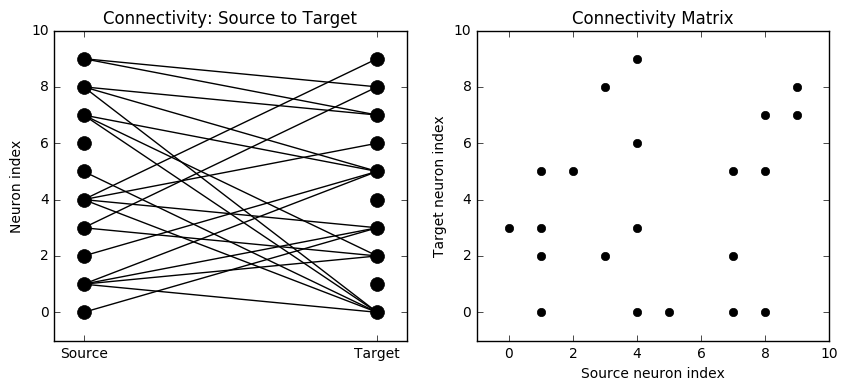

In [55]:
def visualize_connectivity(S):
    Ns = len(S.source) # number of source neurons
    Nt = len(S.target) # number of target neurons
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10) # draw source neurons
    plot(ones(Nt), arange(Nt), 'ok', ms=10) # draw target neurons
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k') # draw lines between them
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    title('Connectivity: Source to Target')
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')
    title('Connectivity Matrix')
    
visualize_connectivity(S)

On the left-hand side, we see a vertical line of circles indicating source neurons on the left, a vertical line indicating target neurons of the right, and a line between two neurons that have a synapse connection. On the right-hand side is another way of visualizing the same connectivity; here, each black dot is a synapse, with `x` value corresponding to the source neuron index and `y` values corresponding to the target neuron index.

Let's see how these figures change as we change the probability of a connection:

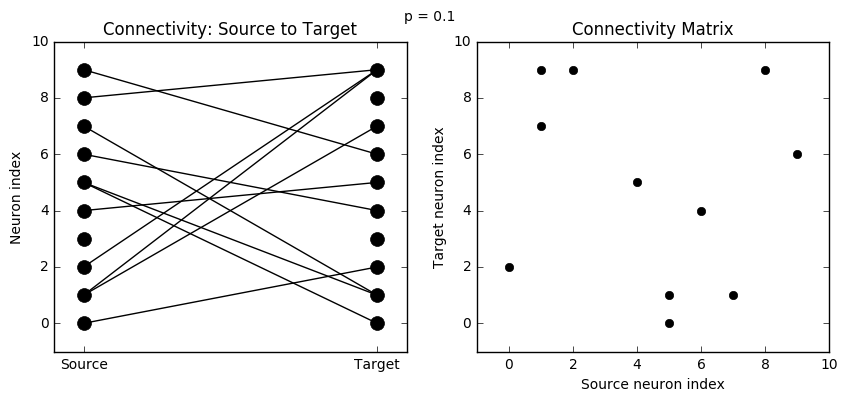

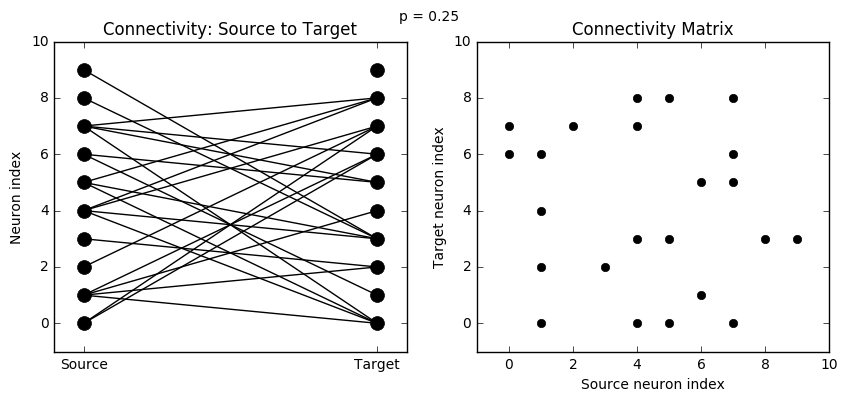

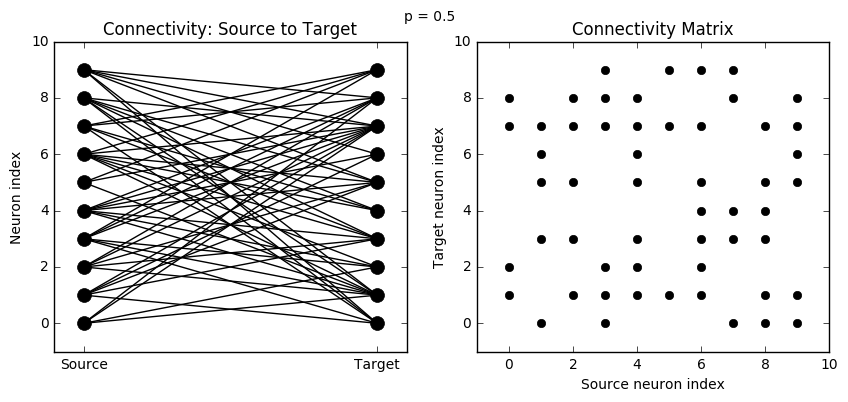

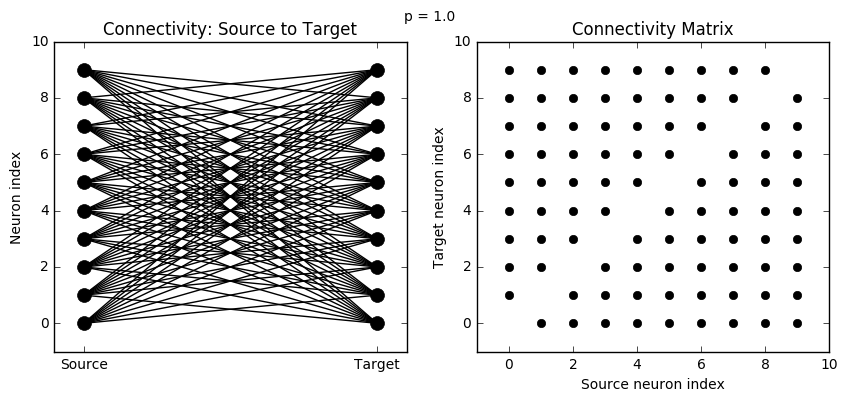

In [58]:
start_scope()

N = 10 # number of neurons
G = NeuronGroup(N, 'v : 1') # neuron group object

# try several different connectivity probabilities
for p in [0.1, 0.25, 0.5, 1.0]:
    S = Synapses(G, G) # create synapse object for neuron group
    S.connect(condition='i!=j', p=p) # create arbitrary source -> target connections (i != j) with probability p
    visualize_connectivity(S) # visualize the connectivity pattern
    suptitle('p = ' + str(p))

Let’s see what another connectivity condition looks like. This will only connect neighbouring neurons.

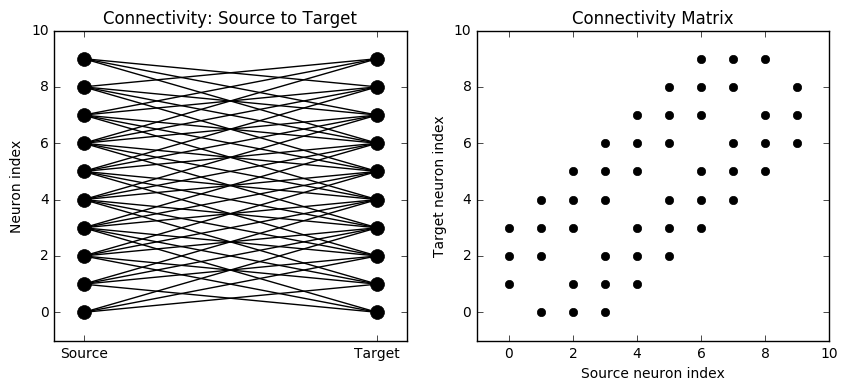

In [65]:
start_scope()

N = 10 # number of neurons
G = NeuronGroup(N, 'v : 1') # neuron group object

S = Synapses(G, G) # synapse object for neuron group
S.connect(condition='abs(i - j) < 4 and i != j') # connects neighbors with 3 steps or less
visualize_connectivity(S) # take a look at the connectivity pattern

We can also use the generator syntax to create connections like this more efficiently. In small examples, this doesn't really matter, but for large numbers of neurons it can be much more efficient to specify directly which neurons should be connected than to specify just a condition.

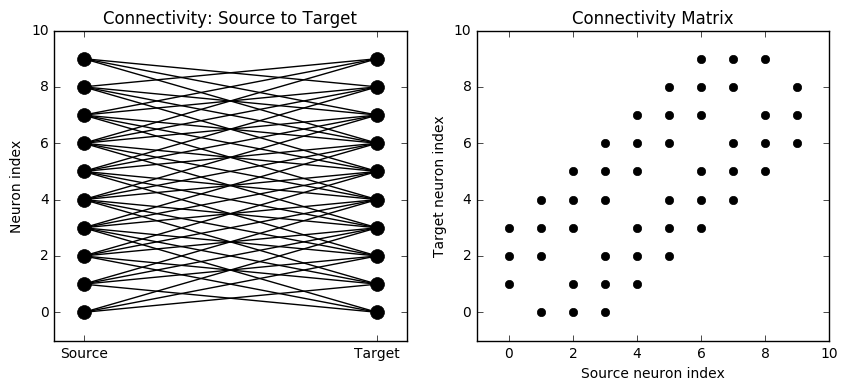

In [66]:
start_scope()

N = 10
G = NeuronGroup(N, 'v : 1')

S = Synapses(G, G)
S.connect(j='k for k in range(clip(i - 3, 0, N_post), clip(i + 4, 0, N_post)) if i!=k')
visualize_connectivity(S)

If each source neuron is connected to precisely one target neuron, there is a special syntax that is extremely efficient. For example, one-to-one connectivity looks like this:

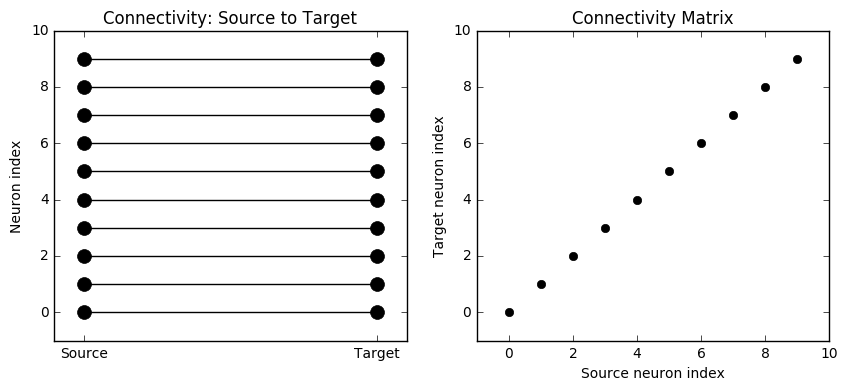

In [67]:
start_scope()

N = 10 # number of neurons
G = NeuronGroup(N, 'v:1') # neuron group object

S = Synapses(G, G) # synapse object for neuron group
S.connect(j='i') # one to one connectivity
visualize_connectivity(S) # visualize it

We can also do things like specifying the values of weights with a string. Let's see an example where we assign each neuron a spatial location, and have a distance-dependent connectivity function. We visualize the weight of a synapse by the size of the marker.

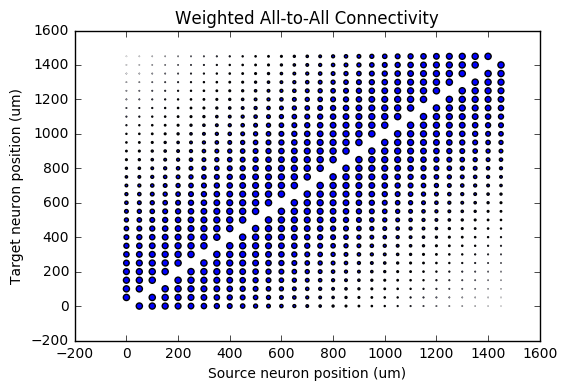

In [73]:
start_scope()

N = 30 # number of neurons
neuron_spacing = 50*umetre # physical spacing between the neurons
width = N / 4.0 * neuron_spacing # width of network

# neuron has one variable x (its position)
G = NeuronGroup(N, 'x : metre')
G.x = 'i * neuron_spacing'

# all synapses are connected (except for self-connections)
S = Synapses(G, G, 'w : 1')
S.connect(condition='i != j')

# weight varies with distance
S.w = 'exp(-(x_pre - x_post) ** 2 / (2 * width ** 2))'

scatter(G.x[S.i]/um, G.x[S.j]/um, S.w*20)
xlabel('Source neuron position (um)')
ylabel('Target neuron position (um)')
title('Weighted All-to-All Connectivity');

Reversing the distance weighting function:

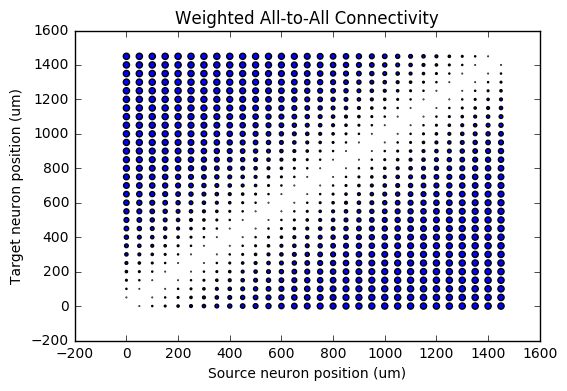

In [75]:
start_scope()

N = 30 # number of neurons
neuron_spacing = 50*umetre # physical spacing between the neurons
width = N / 4.0 * neuron_spacing # width of network

# neuron has one variable x (its position)
G = NeuronGroup(N, 'x : metre')
G.x = 'i * neuron_spacing'

# all synapses are connected (except for self-connections)
S = Synapses(G, G, 'w : 1')
S.connect(condition='i != j')

# weight varies with distance
S.w = '1 - exp(-(x_pre - x_post) ** 2 / (2 * width ** 2))'

scatter(G.x[S.i]/um, G.x[S.j]/um, S.w*20)
xlabel('Source neuron position (um)')
ylabel('Target neuron position (um)')
title('Weighted All-to-All Connectivity');

Just for fun, let's add a connection with weight `exp(-(x_pre - x_post) ** 2 / (2 * width ** 2))` with probability `exp(-(x_pre - x_post) ** 2 / (2 * width ** 2))`, for all neurons `i` and `j` where the condition `i != j` holds:

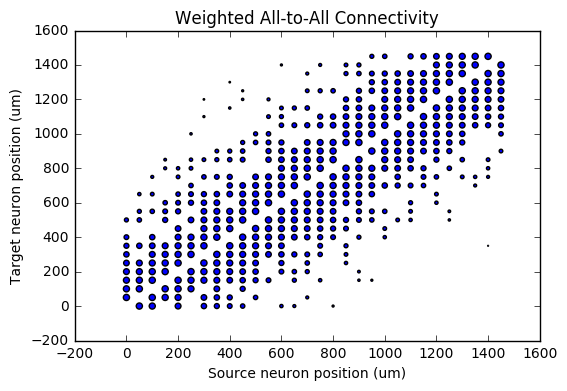

In [74]:
start_scope()

N = 30 # number of neurons
neuron_spacing = 50*umetre # physical spacing between the neurons
width = N / 4.0 * neuron_spacing # width of network

# neuron has one variable x (its position)
G = NeuronGroup(N, 'x : metre')
G.x = 'i * neuron_spacing'

# all synapses are connected (except for self-connections)
S = Synapses(G, G, 'w : 1')
S.connect(condition='i != j', p='exp(-(x_pre - x_post) ** 2 / (2 * width ** 2))')

# weight varies with distance
S.w = 'exp(-(x_pre - x_post) ** 2 / (2 * width ** 2))'

scatter(G.x[S.i]/um, G.x[S.j]/um, S.w*20)
xlabel('Source neuron position (um)')
ylabel('Target neuron position (um)')
title('Weighted All-to-All Connectivity');

## More Complex Synapse Models: STDP

`brian2`'s synapse framework is very general and can do things like short-term plasticity (STP) or spike-timing dependent plasticity (STDP). Let's see how it works for STDP.

STDP is normally defined by an equation something like this:

<center>$\Delta w = \sum_{t_{\text{pre}}} \sum_{t_{\text{post}}} W(t_{\text{pre}} - t_{\text{post}})$.</center>

That is, the change in synaptic weight $w$ is the sum over all presynaptic spike times $t_{\text{pre}}$ and postsynaptic spike times $t_{\text{post}}$ of some function $W$ of the difference in these spike times. A commonly used function $W$ is:

<center>$W(\Delta t) = \begin{cases}
A_{pre} e^{-\Delta t/\tau_{pre}} & \Delta t>0 \\
A_{post}- e^{\Delta t/\tau_{pre}} & \Delta t<0
\end{cases}$</center>

This function looks like this:

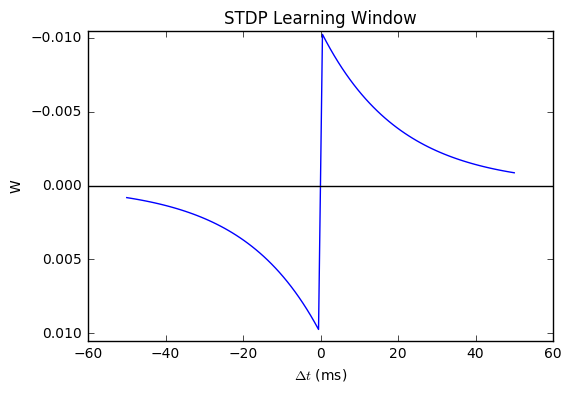

In [76]:
tau_pre = tau_post = 20 * ms # time scales
A_pre = 0.01 # pre-postsynaptic spike plasticity scaling constant
A_post = -A_pre * 1.05 # post-postsynaptic spike plasticity scaling constant
delta_t = linspace(-50, 50, 100) * ms # 100 evenly spaced points in [-50, 50]
W = where(delta_t < 0, A_pre*exp(delta_t/tau_pre), A_post*exp(-delta_t/tau_post)) # defines STDP learning window

# plotting
plot(delta_t/ms, W)
xlabel(r'$\Delta t$ (ms)')
ylabel('W')
ylim(-A_post, A_post)
axhline(0, ls='-', c='k')
title('STDP Learning Window');

Simulating STDP directly using this equation would be very inefficient because we would have to sum over all pairs of spikes, which is physiologically unrealistic since the neuron can't remember all of its previous spike times. It turns out there is a more efficient and physiologically plausible way to get the same effect.

We define two new variables $a_{\text{pre}}$ and $a_{\text{post}}$ which correspond to "traces" of pre- and postsynaptic activity, given by the following differential equations:

<center>$\tau_{\text{pre}} \frac{d}{dt} a_{\text{pre}} = -a_{\text{pre}}$</center>

<center>$\tau_{\text{post}} \frac{d}{dt} a_{\text{pre}} = -a_{\text{post}}$</center>

When a presynaptic spike occurs, the presynaptic trace is updated and the weight is modified according to the rule:

<center>$a_{\text{pre}} \rightarrow a_{\text{pre}} + A_{\text{pre}}$</center>
<center>$w \rightarrow w + a_{\text{post}}$</center>

When a postsynaptic spike occurs:

<center>$a_{\text{post}} \rightarrow a_{\text{post}} + A_{\text{post}}$</center>
<center>$w \rightarrow w + a_{\text{pre}}$</center>

To see that this formulation is equivalent, you simply have to check that the equations sum linearly, and consider the following two cases: what happens if the presynaptic spike occurs before the postsynaptic spike, and vice versa. Try drawing a picture of it.

Now that we have a formulation which relies only on differential equations and spike events, we can turn that into `brian2` code.

In [79]:
start_scope()

taupre = taupost = 20 * ms # time scales
wmax = 0.01 # max weight magnitude
Apre = 0.01 # presynaptic plasticity scaling constant
Apost = -Apre * taupre / taupost * 1.05 # postsynaptic scaling constant

# neuron group object
G = NeuronGroup(1, 'v : 1', threshold='v > 1')

# equations for weights, trace decay
synapse_eqs = '''
w : 1
dapre/dt = -apre / taupre : 1 (event-driven)
dapost/dt = -apost / taupost : 1 (event-driven)
'''

# equations for presynaptic spike
on_pre = '''
v_post += w
apre += Apre
w = clip(w + apost, 0, wmax)
'''

# equations for postsynaptic spike
on_post = '''
apost += Apost
w = clip(w + apre, 0, wmax)
'''

# creating synapses object for neuron group
S = Synapses(G, G, synapse_eqs, on_pre=on_pre, on_post=on_post)

First, when defining the synapses, we've given a more complicated multi-line string defining three synaptic variables (`w`, `apre`, and `apost`). We've also got a new bit of syntax `(event-driven)` after the definitions of `apre` and `apost`. This means that although these two variables evolve continuously over time, `brian2` should only update them at the time of an event (a spike). This is because we don't need the values of `apre` and `apost` expect at spike times, and it's more efficient to only update them as needed.

Next, we have an `on_pre=` argument. The first line is `v_post += w`; this is the line that actually applies the synaptic weight to the target neuron membrane potential. The second line is `apre += Apre` which encodes the rule above. In the third line, we're also encoding the rule above, but we've added one extra feature: we've clamped the synaptic weights between a minimum of 0 and a maximum of `wmax` so that the weights can't get too large or negative. The function `clip(x, low, high)` does this.

Lastly, we have an `on_post=` argument. This gives the statements to calculate when a postsynaptic neuron fires. Note that we don't modify `v` in this case, only the synaptic variables.

Let's see how all the variables behave when a presynaptic spike arrives some time before a postsynaptic spike.

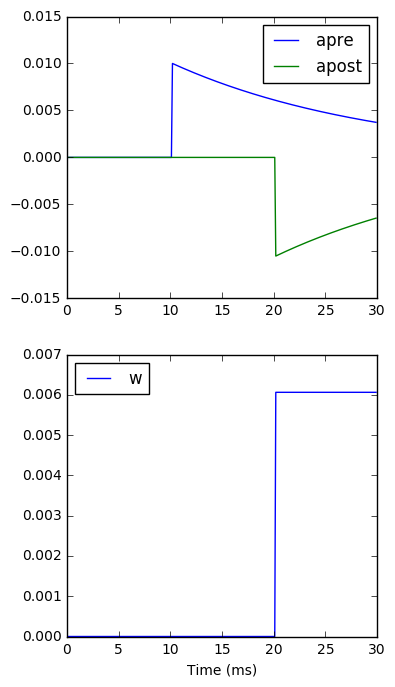

In [85]:
start_scope()

taupre = taupost = 20 * ms # time scales
wmax = 0.01 # max weight magnitude
Apre = 0.01 # presynaptic plasticity scaling constant
Apost = -Apre * taupre / taupost * 1.05 # postsynaptic scaling constant

# neuron group object
G = NeuronGroup(2, 'v:1', threshold='t > (1 + i) * 10 * ms', refractory=100*ms, method='linear')

# equations for weights, trace decay
synapse_eqs = '''
w : 1
dapre/dt = -apre / taupre : 1 (clock-driven)
dapost/dt = -apost / taupost : 1 (clock-driven)
'''

# equations for presynaptic spike
on_pre = '''
v_post += w
apre += Apre
w = clip(w + apost, 0, wmax)
'''

# equations for postsynaptic spike
on_post = '''
apost += Apost
w = clip(w + apre, 0, wmax)
'''

# creating synapses object for neuron group
S = Synapses(G, G, synapse_eqs, on_pre=on_pre, on_post=on_post, method='linear')

# connecting the first neuron to the second
S.connect(i=0, j=1)

# state monitor object
M = StateMonitor(S, ['w', 'apre', 'apost'], record=True)

# run the simulation
run(30*ms)

# plotting
figure(figsize=(4, 8))
subplot(211)
plot(M.t/ms, M.apre[0], label='apre')
plot(M.t/ms, M.apost[0], label='apost')
legend(loc='best')
subplot(212)
plot(M.t/ms, M.w[0], label='w')
legend(loc='best')
xlabel('Time (ms)');

We've used a trick to make neuron 0 fire a spike at time 10ms, and neuron 1 at time 20ms. Can you see how that works? _This is caused by the_ `threshold` _argument to the neuron group object._

Secondly, we’ve replaced the (event-driven) by (clock-driven) so you can see how apre and apost evolve over time. If we revert this change, the graph of `apre` and `apost` only show the values changing from their intitial settings to their value at the event, and staying there.

Finally, let’s verify that this formulation is equivalent to the original one.

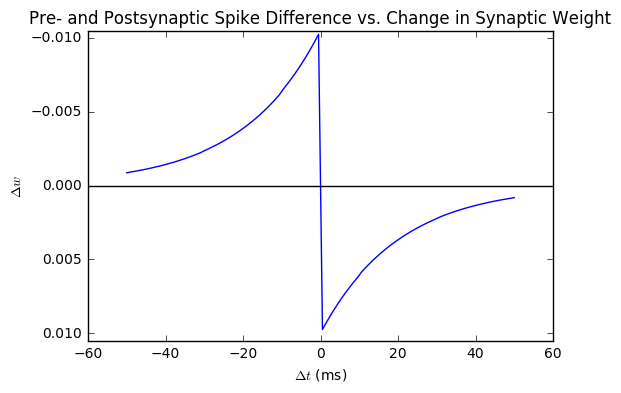

In [88]:
start_scope()

# pre- and postsynaptic time scales, scaling constants, maximum time, and number of neurons
taupre = taupost = 20 * ms
Apre = 0.01
Apost = -Apre * taupre / taupost * 1.05
tmax = 50 * ms
N = 100

# Presynaptic neurons G spike at times from 0 to tmax
# Postsynaptic neurons H spike at times from tmax to 0
# So difference in spike times will vary from -tmax to +tmax
G = NeuronGroup(N, 'tspike : second', threshold='t > tspike', refractory=100 * ms)
H = NeuronGroup(N, 'tspike : second', threshold='t > tspike', refractory=100 * ms)
G.tspike = 'i * tmax / (N - 1)'
H.tspike = '(N - 1 - i) * tmax / (N - 1)'

# synapse equations, pre- and postsynaptic trace and weight updates
synapse_eqs = '''
w : 1
dapre/dt = -apre/taupre : 1 (event-driven)
dapost/dt = -apost/taupost : 1 (event-driven)
'''
on_pre = '''
apre += Apre
w = w + apost
'''
on_post = '''
apost += Apost
w = w + apre
'''

# synapses object from neuron group G to H
S = Synapses(G, H, synapse_eqs, on_pre=on_pre, on_post=on_post)
# one-to-one connectivity
S.connect(j='i')

# run the simulation
run(tmax + 1 * ms)

# plotting
plot((H.tspike-G.tspike)/ms, S.w)
xlabel(r'$\Delta t$ (ms)')
ylabel(r'$\Delta w$')
ylim(-Apost, Apost)
axhline(0, ls='-', c='k')
title('Pre- and Postsynaptic Spike Difference vs. Change in Synaptic Weight');

Can you see how this works? _As the firing times of the neurons in_ `G` _range from_ `t = 0` _to_ `tmax`, the firing times in_ `H` _range in the opposite direction. At first, $\Delta t$ is very negative, and gives a small positive weight change, and grows exponentially until $\Delta t = 0$, at which which point the sign of the weight change flips (along with the sign of $\Delta t$), and as we move further right, the weight change is negative but exponentially decreasing in magnitude._